# Выбор локации для скважины

Допустим, мы работаем в добывающей компании. Нужно решить, где бурить новую скважину.

В нашем распоряжении данные о пробах нефти из трёх регионов: в каждом 100 000 месторождений, где измерили качество нефти и объём её запасов. 
**Задачи:**
1. Построить модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль.
2. Проанализировать возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе собирают характеристики для скважин: качество нефти и объём её запасов;
- Строят модель для предсказания объёма запасов в новых скважинах;
- Выбирают скважины с самыми высокими оценками значений;
- Определяют регион с максимальной суммарной прибылью отобранных скважин.

**Описание данных**
- id — уникальный идентификатор скважины;
- f0, f1, f2 — три признака точек;
- product — объём запасов в скважине (тыс. баррелей).

## Загрузка и подготовка данных

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from numpy.random import RandomState

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_squared_error

from scipy.interpolate import interp1d

In [2]:
df1 = pd.read_csv('/datasets/geo_data_0.csv')
df2 = pd.read_csv('/datasets/geo_data_1.csv')
df3 = pd.read_csv('/datasets/geo_data_2.csv')

In [3]:
display(df1.head())
display(df2.head())
display(df3.head())

,id,f0,f1,f2,product
0,txEyH,0.705745,-0.497823,1.221170,105.280062
1,2acmU,1.334711,-0.340164,4.365080,73.037750
2,409Wp,1.022732,0.151990,1.419926,85.265647
3,iJLyR,-0.032172,0.139033,2.978566,168.620776
4,Xdl7t,1.988431,0.155413,4.751769,154.036647


,id,f0,f1,f2,product
0,kBEdx,-15.001348,-8.276000,-0.005876,3.179103
1,62mP7,14.272088,-3.475083,0.999183,26.953261
2,vyE1P,6.263187,-5.948386,5.001160,134.766305
3,KcrkZ,-13.081196,-11.506057,4.999415,137.945408
4,AHL4O,12.702195,-8.147433,5.004363,134.766305


,id,f0,f1,f2,product
0,fwXo0,-1.146987,0.963328,-0.828965,27.758673
1,WJtFt,0.262778,0.269839,-2.530187,56.069697
2,ovLUW,0.194587,0.289035,-5.586433,62.871910
3,q6cA6,2.236060,-0.553760,0.930038,114.572842
4,WPMUX,-0.515993,1.716266,5.899011,149.600746


In [4]:
print(df1.info())
print('')
print(df2.info())
print('')
print(df3.info())
print('')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memory usage: 3.8+ MB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 5 columns):
id         100000 non-null object
f0         100000 non-null float64
f1         100000 non-null float64
f2         100000 non-null float64
product    100000 non-null float64
dtypes: float64(4), object(1)
memor

In [5]:
print(df1.duplicated().sum())
print(df2.duplicated().sum())
print(df3.duplicated().sum())

0
0
0


In [6]:
display(df1.describe())
display(df2.describe())
display(df3.describe())

,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.500419,0.250143,2.502647,92.500000
std,0.871832,0.504433,3.248248,44.288691
min,-1.408605,-0.848218,-12.088328,0.000000
25%,-0.072580,-0.200881,0.287748,56.497507
50%,0.502360,0.250252,2.515969,91.849972
75%,1.073581,0.700646,4.715088,128.564089
max,2.362331,1.343769,16.003790,185.364347


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,1.141296,-4.796579,2.494541,68.825000
std,8.965932,5.119872,1.703572,45.944423
min,-31.609576,-26.358598,-0.018144,0.000000
25%,-6.298551,-8.267985,1.000021,26.953261
50%,1.153055,-4.813172,2.011479,57.085625
75%,8.621015,-1.332816,3.999904,107.813044
max,29.421755,18.734063,5.019721,137.945408


,f0,f1,f2,product
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,0.002023,-0.002081,2.495128,95.000000
std,1.732045,1.730417,3.473445,44.749921
min,-8.760004,-7.084020,-11.970335,0.000000
25%,-1.162288,-1.174820,0.130359,59.450441
50%,0.009424,-0.009482,2.484236,94.925613
75%,1.158535,1.163678,4.858794,130.595027
max,7.238262,7.844801,16.739402,190.029838


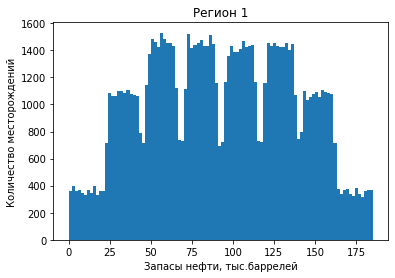

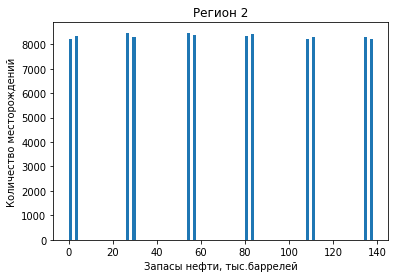

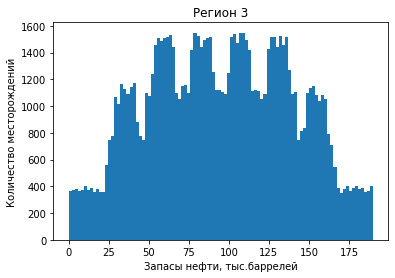

In [7]:
df1['product'].plot(kind='hist', bins=100)
plt.title('Регион 1')
plt.xlabel('Запасы нефти, тыс.баррелей')
plt.ylabel('Количество месторождений')
plt.show()

df2['product'].plot(kind='hist', bins=100)
plt.title('Регион 2')
plt.xlabel('Запасы нефти, тыс.баррелей')
plt.ylabel('Количество месторождений')
plt.show()

df3['product'].plot(kind='hist', bins=100)
plt.title('Регион 3')
plt.xlabel('Запасы нефти, тыс.баррелей')
plt.ylabel('Количество месторождений')
plt.show()


### Вывод

В качестве входных данных нам представлены 3 датасета с информацией о месторождениях нефти. Каждый датасет содержит 100000 строк и 5 столбцов: индивидуальный ID месторождения; 3 признака f0, f1, f2, о которых известно только то, что они являются значимыми; объем запасов нефти в тыс. баррелей.

Данные представлены корректно. Пропуски отсутствуют, дубликаты тоже.

Отметим необычный вид распределения месторождений во втором регионе. Похоже, что во втором регионе всего 6 месторождений, и из каждого было взято одинаковое количество проб.

## Обучение и проверка модели

**2.1. Разбиение данных на выборки**

Создадим переменные с признаками и с целевым признаком для каждого датасета.

In [8]:
df1_features = df1.drop(['id', 'product'], axis=1)
df1_target = df1['product']

df2_features = df2.drop(['id', 'product'], axis=1)
df2_target = df2['product']

df3_features = df3.drop(['id', 'product'], axis=1)
df3_target = df3['product']

Разделим данные на обучающую и валидационную выборки в соотношении 75:25.

In [9]:
df1_features_train, df1_features_valid, df1_target_train, df1_target_valid, \
        df2_features_train, df2_features_valid, df2_target_train, df2_target_valid, \
        df3_features_train, df3_features_valid, df3_target_train, df3_target_valid = \
        train_test_split(
        df1_features, df1_target, df2_features, df2_target, df3_features, df3_target, \
        test_size=0.25, random_state=123)


df1_target_valid = df1_target_valid.reset_index(drop=True)
df2_target_valid = df2_target_valid.reset_index(drop=True)
df3_target_valid = df3_target_valid.reset_index(drop=True)

print(df1_features_train.shape)
print(df1_features_valid.shape)
print(df1_target_train.shape)
print(df1_target_valid.shape)
print(df2_features_train.shape)
print(df2_features_valid.shape)
print(df2_target_train.shape)
print(df2_target_valid.shape)
print(df3_features_train.shape)
print(df3_features_valid.shape)
print(df3_target_train.shape)
print(df3_target_valid.shape)

(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)
(75000, 3)
(25000, 3)
(75000,)
(25000,)


**2.2. Обучение модели и предсказания на валидационной выборке для каждого региона**

In [10]:
model1 = LinearRegression()
model1.fit(df1_features_train, df1_target_train)
predictions1 = model1.predict(df1_features_valid)

model2 = LinearRegression()
model2.fit(df2_features_train, df2_target_train)
predictions2 = model2.predict(df2_features_valid)

model3 = LinearRegression()
model3.fit(df3_features_train, df3_target_train)
predictions3 = model3.predict(df3_features_valid)

**2.3. Определение среднего запаса и RMSE модели**

In [11]:
rmse1 = mean_squared_error(df1_target_valid, predictions1)**0.5
rmse2 = mean_squared_error(df2_target_valid, predictions2)**0.5
rmse3 = mean_squared_error(df3_target_valid, predictions3)**0.5

print('Средний запас предсказанного сырья в регионе 1: {:.3f} тыс.баррелей'.format(predictions1.mean()))
print('RMSE модели для первого региона равно {:.3f} тыс.баррелей'.format(rmse1))
print('Средний запас предсказанного сырья в регионе 2: {:.3f} тыс.баррелей'.format(predictions2.mean()))
print('RMSE модели для вторго региона равно {:.3f} тыс.баррелей'.format(rmse2))
print('Средний запас предсказанного сырья в регионе 3: {:.3f} тыс.баррелей'.format(predictions3.mean()))
print('RMSE модели для третьего региона равно {:.3f} тыс.баррелей'.format(rmse3))

Средний запас предсказанного сырья в регионе 1: 92.549 тыс.баррелей
RMSE модели для первого региона равно 37.648 тыс.баррелей
Средний запас предсказанного сырья в регионе 2: 69.280 тыс.баррелей
RMSE модели для вторго региона равно 0.895 тыс.баррелей
Средний запас предсказанного сырья в регионе 3: 95.099 тыс.баррелей
RMSE модели для третьего региона равно 40.128 тыс.баррелей


Проверим RMSE константной модели для каждого региона

In [12]:
const_predictions1 = pd.Series(df1_target_valid.mean(), index=df1_target_valid.index)
const_predictions2 = pd.Series(df2_target_valid.mean(), index=df2_target_valid.index)
const_predictions3 = pd.Series(df3_target_valid.mean(), index=df3_target_valid.index)

const_rmse1 = mean_squared_error(df1_target_valid, const_predictions1)**0.5
const_rmse2 = mean_squared_error(df2_target_valid, const_predictions2)**0.5
const_rmse3 = mean_squared_error(df3_target_valid, const_predictions3)**0.5

print('RMSE константной модели для первого региона равно {:.3f} тыс.баррелей'.format(const_rmse1))
print('RMSE константной модели для второго региона равно {:.3f} тыс.баррелей'.format(const_rmse2))
print('RMSE константной модели для третьего региона равно {:.3f} тыс.баррелей'.format(const_rmse3))

RMSE константной модели для первого региона равно 44.408 тыс.баррелей
RMSE константной модели для второго региона равно 45.819 тыс.баррелей
RMSE константной модели для третьего региона равно 44.673 тыс.баррелей


**2.4. Вывод**

Данные разбиты на выборки, модели обучены, предсказания сделаны.

По результатам предсказаний видно, что среднее предсказанных значений по каждому региону близко к среднему, полученному в первичном анализе данных.

RMSE модели для второго региона подозрительно низкое по сравнению с 1 и 3 регионами. Скорее всего, это вызвано очень небольшим разбросом в данных (что видно из графиков в первичном анализе).
RMSE 1 и 3 регионов незначительно меньше RMSE константных моделей.

## Подготовка к расчёту прибыли

Создадим переменные с исходными данными

In [13]:
BUDGET = 10000000000
PRISE = 450000
N = 200
budget_per_one = BUDGET / N

Посчитаем достаточный объём сырья для безубыточной разработки новой скважины

In [14]:
min_product = budget_per_one / PRISE
print('Достаточный объём сырья для безубыточной разработки новой скважины =', min_product)

Достаточный объём сырья для безубыточной разработки новой скважины = 111.11111111111111


**Вывод**

Для безубыточной разработки скважины необходимо разрабатывать скважину, запасы в которой минимум на 20% превосходят средние по региону.

## Расчёт прибыли и рисков 

Выберем в каждом регионе 200 лучших месторождений для разработки из 500 исследуемых случайных точек. Применим технику Bootstrap и повторим выборку месторождений 1000 раз. Для каждой попытки определим прибыль.

In [15]:
predictions1 = pd.Series(predictions1)
predictions2 = pd.Series(predictions2)
predictions3 = pd.Series(predictions3)

state = np.random.RandomState(123)

In [16]:
def profit(target, predictions):
    
    incomes = []
    
    for i in range(1000):
        predicted = predictions.sample(n=500, random_state = state)
        predicted_top = predicted.sort_values(ascending=False)[:200]
        real_top = target.loc[predicted_top.index]
        incomes.append(real_top.sum() * PRISE - BUDGET)
    return incomes


In [17]:
incomes1 = pd.Series(profit(df1_target_valid, predictions1))
incomes2 = pd.Series(profit(df2_target_valid, predictions2))
incomes3 = pd.Series(profit(df3_target_valid, predictions3))

Посчитаем среднюю прибыль для каждого региона и определим 95% доверительный интервал прибыли.

In [18]:
incomes1 = pd.Series(incomes1)
incomes2 = pd.Series(incomes2)
incomes3 = pd.Series(incomes3)

lower1 = incomes1.quantile(.025)/1000000
upper1 = incomes1.quantile(.975)/1000000
lower2 = incomes2.quantile(.025)/1000000
upper2 = incomes2.quantile(.975)/1000000
lower3 = incomes3.quantile(.025)/1000000
upper3 = incomes3.quantile(.975)/1000000

print('В первом регионе средняя прибыль равна {:.2f} млн.руб, 95% доверительный интервал ({:.2f}, {:.2f})'.format(incomes1.mean()/1000000, lower1, upper1))
print('Во втором регионе средняя прибыль равна {:.2f} млн.руб, 95% доверительный интервал ({:.2f}, {:.2f})'.format(incomes2.mean()/1000000, lower2, upper2))
print('В третьем регионе средняя прибыль равна {:.2f} млн.руб, 95% доверительный интервал ({:.2f}, {:.2f})'.format(incomes3.mean()/1000000, lower3, upper3))

В первом регионе средняя прибыль равна 485.56 млн.руб, 95% доверительный интервал (-0.12, 992.86)
Во втором регионе средняя прибыль равна 462.94 млн.руб, 95% доверительный интервал (66.70, 843.04)
В третьем регионе средняя прибыль равна 351.56 млн.руб, 95% доверительный интервал (-193.35, 847.38)


В первом и третьем регионах есть риск убытков. Во втором регионе можно безубыточно разрабатывать скважину.

In [19]:
print('Риск получить отрицательную прибыль в первом регионе составляет {:.2%}'.format((incomes1 < 0).mean()))
print('Риск получить отрицательную прибыль в третьем регионе составляет {:.2%}'.format((incomes3 < 0).mean()))

Риск получить отрицательную прибыль в первом регионе составляет 2.50%
Риск получить отрицательную прибыль во втором регионе составляет 1.20%


## Вывод

В работе были проанализированы 3 региона с месторождениями нефти. Для каждого региона была обучена модель и предсказаны значения запасов нефти в скважинах.

К предсказаниям была применена техника Bootstrap для определения разброса прибылей.

По результатам анализа получилось, что риски понести убытки не превышают 2,5% только в первом и втором регионах. В 3 регионе риски убытков равны 9,1%, что слишком много для разработки там скважины. 

Рекомендуется разрабатывать первый регион, в котором средняя прибыль равна 485,56 млн.руб и присутствует риск 2,5% понести убытки. В данном регионе самая высокая средняя прибыль и самая высокая максимально возможная прибыль. Риски понести убытки достаточно малы, чтобы не отказываться от данного региона.